# **1. Imports**

In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# **2. torch.nn.Embedding**

## A. 임베딩 레이어

In [ ]:
`-` motive : torch.nn.functional.one_hot + torch.nn.Linear를 매번 쓰는 건 너무 귀찮은데??

In [8]:
torch.manual_seed(43052)
#x = ['옥순','영숙','하니','옥순','영숙']
x = torch.tensor([0,1,2,0,1])
E = torch.nn.functional.one_hot(x).float()
linr = torch.nn.Linear(3,1,bias=False) 
lf = linr(E)
lf

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<MmBackward0>)

In [13]:
linr.weight

Parameter containing:
tensor([[-0.2002, -0.4890,  0.2081]], requires_grad=True)

In [23]:
torch.concat([linr(E) , E @ linr.weight.T],axis=1)

tensor([[-0.2002, -0.2002],
        [-0.4890, -0.4890],
        [ 0.2081,  0.2081],
        [-0.2002, -0.2002],
        [-0.4890, -0.4890]], grad_fn=<CatBackward0>)

`-` torch.nn.functional.one_hot + torch.nn.Linear를 함께 처리해주는 레이어 torch.nn.Embedding 존재

In [24]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(3,1) 
ebdd.weight.data = linr.weight.data.T
ebdd(x)

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<EmbeddingBackward0>)

`?` 굳이 one_hot인코딩을 해야하나? 안하고 바로 linear하면 안되나?

`-` linear.weight가 각각의 데이터에 개별마다 서로 다른 weight가 적용되어야하는데 one_hot인코딩을 하지 않으면 개별적으로 적용되지 않음.

## B. MF-based 추천시스템 재설계

In [31]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [32]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

임베딩레이어를 활용하여 MF-based 추천시스템을 설계하라.

In [51]:
torch.manual_seed(43052)
ebdd1 = torch.nn.Embedding(9,2)
b1 = torch.nn.Embedding(9,1)
ebdd2 = torch.nn.Embedding(8,2)
b2 = torch.nn.Embedding(8,1)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(ebdd1.parameters()) + list(b1.parameters()) + list(ebdd2.parameters()) + list(b2.parameters())
optimizr = torch.optim.Adam(params , lr=0.1)
#--#
for epoc in range(100):
    # 1
    W_features = ebdd1(X1)
    W_bias = b1(X1)
    M_features = ebdd2(X2)
    M_bias = b2(X2)
    score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score) * 5
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [52]:
torch.concat([yhat,y],axis=1)[::4]

tensor([[4.1083, 4.0200],
        [0.9388, 1.1200],
        [4.0483, 3.9900],
        [0.9707, 0.9600],
        [4.2264, 4.0500],
        [0.9518, 0.9900],
        [0.5124, 0.5600],
        [1.1198, 1.1200],
        [4.0588, 4.1600],
        [1.0596, 1.0500],
        [3.9666, 3.7800],
        [0.9472, 0.8800],
        [3.9194, 4.0400],
        [1.0346, 1.0300],
        [4.8851, 4.8500],
        [4.5387, 4.3900]], grad_fn=<SliceBackward0>)

`-` Nan값들을 추출하고 싶다면? 아래와 같이 진행

In [55]:
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
df_test = pd.DataFrame({'W':['옥순(IN)','보람(ES)','하니(I)'],'M':['영식(IN)','다호(ES)','영호(IS)']})
XX1 = torch.tensor(df_test['W'].map(w))
XX2 = torch.tensor(df_test['M'].map(m))

ebdd1 = torch.nn.Embedding(9,2)
b1 = torch.nn.Embedding(9,1)
ebdd2 = torch.nn.Embedding(8,2)
b2 = torch.nn.Embedding(8,1)

W_features = ebdd1(XX1)
W_bias = b1(XX1)
M_features = ebdd2(XX2)
M_bias = b2(XX2)
score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
yhat = sig(score) * 5
yhat

tensor([[1.8270],
        [2.6058],
        [4.5784]], grad_fn=<MulBackward0>)

# **3. 사용자 정의 네트워크**

## A. 사용자 정의 네트워크 사용법

`-` 예비학습1 : net(x)와 net.forward(x)는 사실 같다.

In [56]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)

In [57]:
X = torch.randn(5,1)
X

tensor([[-1.2804],
        [-0.0382],
        [-0.8600],
        [-1.3291],
        [ 0.0696]])

In [64]:
net(X)

tensor([[0.1890],
        [0.3183],
        [0.2277],
        [0.1849],
        [0.3315]], grad_fn=<SigmoidBackward0>)

In [65]:
net.forward(X)

tensor([[0.1890],
        [0.3183],
        [0.2277],
        [0.1849],
        [0.3315]], grad_fn=<SigmoidBackward0>)

In [66]:
net.forward = lambda x : '메롱'

In [67]:
net.forward(X)

'메롱'

In [68]:
net(X)

'메롱'

`-` 예비학습2 : torch.nn.Module을 상속받아서 네트워크를 만들면 (= class XXX(torch.nn.Module): 과 같은 방식으로 클래스를 선언하면) 약속된 아키텍처를 가진 네트워크를 찍어내는 함수를 만들 수 있다.

예시1)

In [69]:
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1,1)
        self.a1 = torch.nn.Sigmoid()
        self.l2 = torch.nn.Linear(1,1)
    def forward(self,x):
        yhat = self.l2(self.al(self.l1(x)))
        return yhat

net을 내가 만든 네트워크로 받아주기

In [70]:
net = Mynet1()

예시2)

In [71]:
class Mynet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

In [72]:
net = Mynet2()

실습)

In [73]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

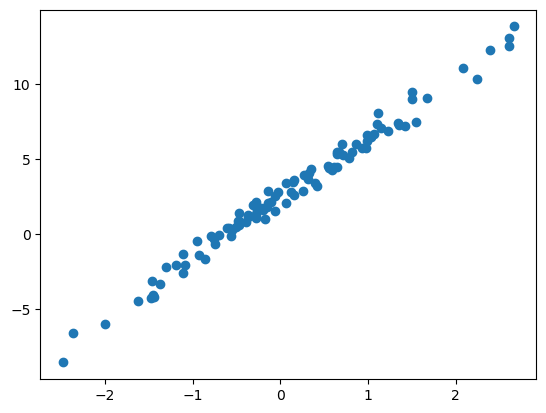

In [74]:
plt.plot(x,y,'o')

In [75]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1,1)
    def forward(self,x):
        yhat = self.l1(x)
        return yhat

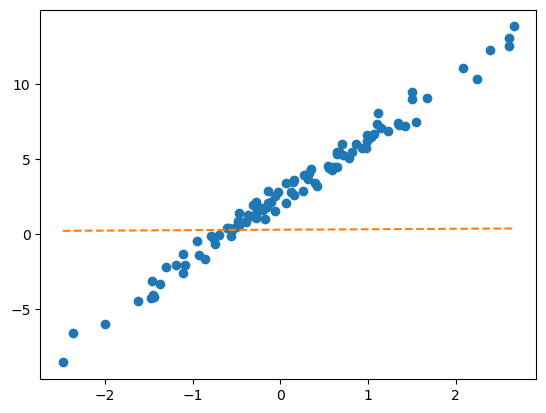

In [76]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--') # 최초의 직선

In [84]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

for epoc in range(100):
    yhat = net(x)
    loss = loss_fn(yhat,y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

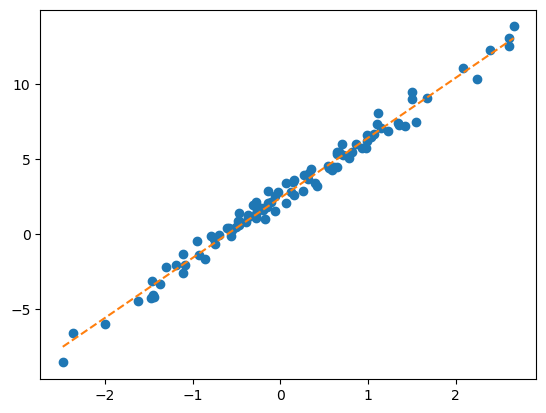

In [85]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--') # 최초의 직선

## B. MF-based 추천시스템 재설계

In [95]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [96]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

사용자 정의 네트워크를 이용하여 MF-based 추천시스템을 설계하라

`-` 풀이1

In [110]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.sig = torch.nn.Sigmoid()
    def forward(self,X1,X2):
        W_features = self.ebdd1(X1)
        M_features = self.ebdd2(X2)
        W_bias = self.b1(X1)
        M_bias = self.b2(X2)
        score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
        yhat = sig(score) * 5
        return yhat

In [111]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

for epoc in range(100):
    yhat = net(X1,X2)
    
    loss = loss_fn(yhat,y)
    
    loss.backward()
    
    optimizr.step()
    optimizr.zero_grad()

In [119]:
torch.concat([yhat.data , y],axis=1)[::5]

tensor([[4.0761, 4.0200],
        [0.5779, 0.4300],
        [3.5008, 3.4300],
        [3.4501, 3.4200],
        [0.9958, 0.9900],
        [0.7196, 0.5200],
        [0.4822, 0.4300],
        [0.8808, 0.9400],
        [3.9193, 3.7800],
        [0.8878, 0.8900],
        [0.5020, 0.4800],
        [4.0130, 3.8200],
        [4.7589, 4.3900]])

`-` 풀이2

In [120]:
X = torch.stack([X1,X2],axis=1)
X[:5]

tensor([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5]])

In [121]:
X[:,0], X[:,1]

(tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8]),
 tensor([1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 6, 7, 0, 1, 3,
         4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 7, 0, 1, 2, 3, 4, 5,
         6, 7, 0, 1, 2, 4, 5, 6, 0, 1, 3, 4, 5, 6, 7]))

In [122]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.sig = torch.nn.Sigmoid()
    def forward(self,X):
        X1,X2 = X[:,0],X[:,1]
        W_features = self.ebdd1(X1)
        M_features = self.ebdd2(X2)
        W_bias = self.b1(X1)
        M_bias = self.b2(X2)
        score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
        yhat = sig(score) * 5
        return yhat

In [123]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--# 
for epoc in range(100):
    # 1
    yhat = net(X) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [124]:
torch.concat([yhat.data,y],axis=1)[::5]

tensor([[4.0690, 4.0200],
        [0.6189, 0.4300],
        [3.5540, 3.4300],
        [3.4387, 3.4200],
        [0.9671, 0.9900],
        [0.6642, 0.5200],
        [0.5653, 0.4300],
        [0.0233, 0.9400],
        [3.8030, 3.7800],
        [0.7846, 0.8900],
        [0.5607, 0.4800],
        [3.8352, 3.8200],
        [4.9609, 4.3900]])

# **4.NN-based 추천시스템**

## A. NN-based 방식

In [125]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [126]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

NN-based 추천시스템을 설계하라

(풀이1) - 실패

`-` W_feature,M_feature,W_bias,M_bias을 모두 concat해서 (nx6)행렬로 만든 후에 linear를 태워볼까?

In [127]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(6,1),
            torch.nn.Sigmoid()
        )   
    def forward(self,X1,X2):
        W_feature = self.ebdd1(X1)
        M_feature = self.ebdd2(X2)
        W_bias = self.b1(X1)
        M_bias = self.b2(X2)
        Z = torch.concat([W_feature,M_feature,W_bias,M_bias],axis=1)
        yhat = self.mlp(Z) * 5 
        return yhat

In [128]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--# 
for epoc in range(1000):
    # 1
    yhat = net(X1,X2) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [129]:
torch.concat([yhat.data,y],axis=1)[::5]

tensor([[2.1565, 4.0200],
        [1.6908, 0.4300],
        [2.6466, 3.4300],
        [2.7758, 3.4200],
        [2.5814, 0.9900],
        [2.3105, 0.5200],
        [2.6402, 0.4300],
        [1.7231, 0.9400],
        [2.3893, 3.7800],
        [2.4106, 0.8900],
        [1.9774, 0.4800],
        [2.0164, 3.8200],
        [4.7447, 4.3900]])

- 안 맞네..?

(풀이2) - 모르겠다... 깊은 신경망 써보자

In [130]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(6,15),
            torch.nn.ReLU(),
            torch.nn.Linear(15,15),
            torch.nn.ReLU(),
            torch.nn.Linear(15,1),
            torch.nn.Sigmoid()
        )   
    def forward(self,X1,X2):
        W_feature = self.ebdd1(X1)
        M_feature = self.ebdd2(X2)
        W_bias = self.b1(X1)
        M_bias = self.b2(X2)
        Z = torch.concat([W_feature,M_feature,W_bias,M_bias],axis=1)
        yhat = self.mlp(Z) * 5 
        return yhat

In [131]:
torch.manual_seed(43052)
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--# 
for epoc in range(1000):
    # 1
    yhat = net(X1,X2) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [132]:
torch.concat([yhat.data,y],axis=1)[::5]

tensor([[4.0304, 4.0200],
        [0.4593, 0.4300],
        [3.4378, 3.4300],
        [3.4342, 3.4200],
        [1.0066, 0.9900],
        [0.5503, 0.5200],
        [0.4410, 0.4300],
        [0.9358, 0.9400],
        [3.8641, 3.7800],
        [0.9078, 0.8900],
        [0.4841, 0.4800],
        [3.8569, 3.8200],
        [4.4065, 4.3900]])

`-` 잘 맞추는데 오버피팅 아니야?

In [133]:
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [134]:
XX1 = torch.tensor([0,1,8])
XX2 = torch.tensor([1,7,2])

In [135]:
net(XX1,XX2)

tensor([[4.0098],
        [0.5043],
        [4.9727]], grad_fn=<MulBackward0>)